In [1]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from functools import reduce
from torch.utils.data.sampler import SubsetRandomSampler

torch.cuda.empty_cache()

In [2]:
# bs=32
# train = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

In [3]:


bs=32*8*2
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=False)

In [4]:
def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


In [5]:
classes=[0,1,2,3,4,5]
num_classes=len([0,1,2])
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=bs,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=bs,sampler=stratified_sampler(test.targets,classes))

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

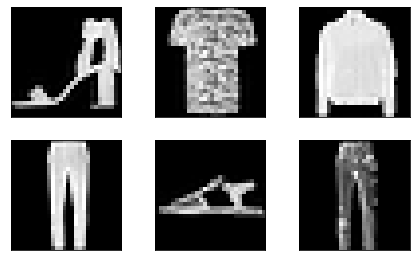

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')

In [28]:
torch.cuda.get_device_name()

'GeForce GTX 1050'

In [29]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [30]:
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [31]:
NNprint_=False
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input

In [32]:

class VAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def sample(self,z):
        return self.decode(z)

In [33]:
image_channels = example_data.size(1)
image_channels

1

In [34]:
model = VAE(image_channels=image_channels,h_dim=1024,z_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [35]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [36]:
epochs=10

In [37]:
%%time
for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
#         print(idx)
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%500==0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                        epochs, loss.data.cpu().numpy().tolist()/bs, bce.data.cpu().numpy().tolist()/bs, kld.data.cpu().numpy().tolist()/bs)
            print(to_print)
torch.save(model.state_dict(), 'vae.torch')


Epoch[1/10] Loss: 527.243 527.243 0.000


KeyboardInterrupt: 

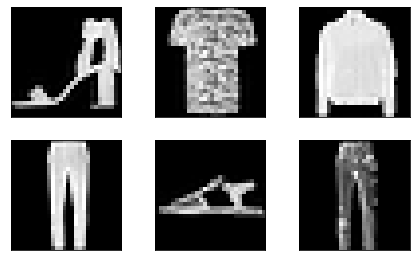

In [38]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

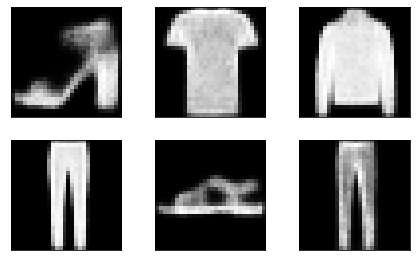

In [20]:
example_data_nn=model(example_data.to(device),example_targets)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data_nn[0][i][0].cpu().data, cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [21]:
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

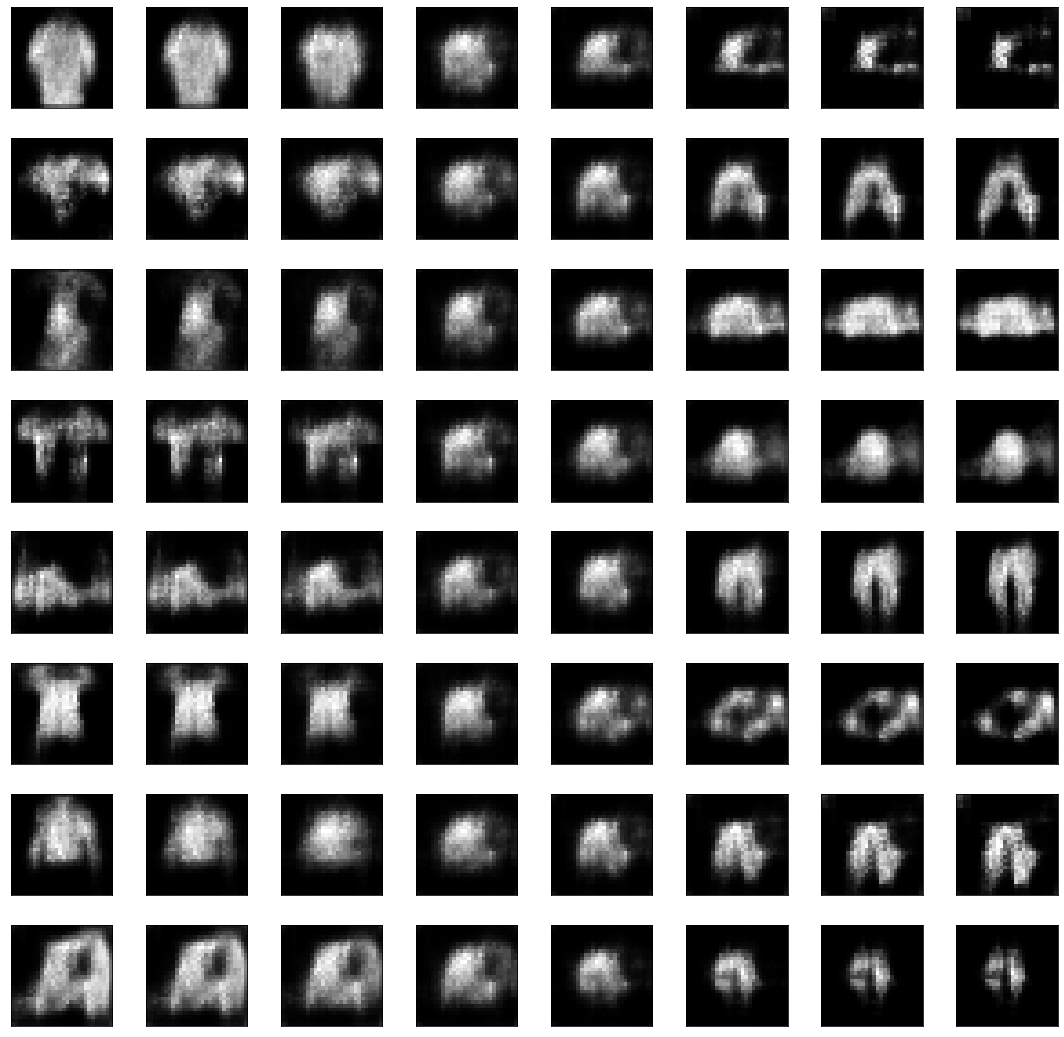

In [26]:
zeros=torch.zeros(10,64)
c=0
for i in zeros:
    
    zeros[c,c]+=1
    c+=1
    if c==10:
        c=0
        
    
range_=np.linspace(3,-3,8)
samples=(torch.ones(8,64)*0).T
for c in range(64):
    samples[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(samples.to(device))
plot_examples(model=True,data=smple_pic)

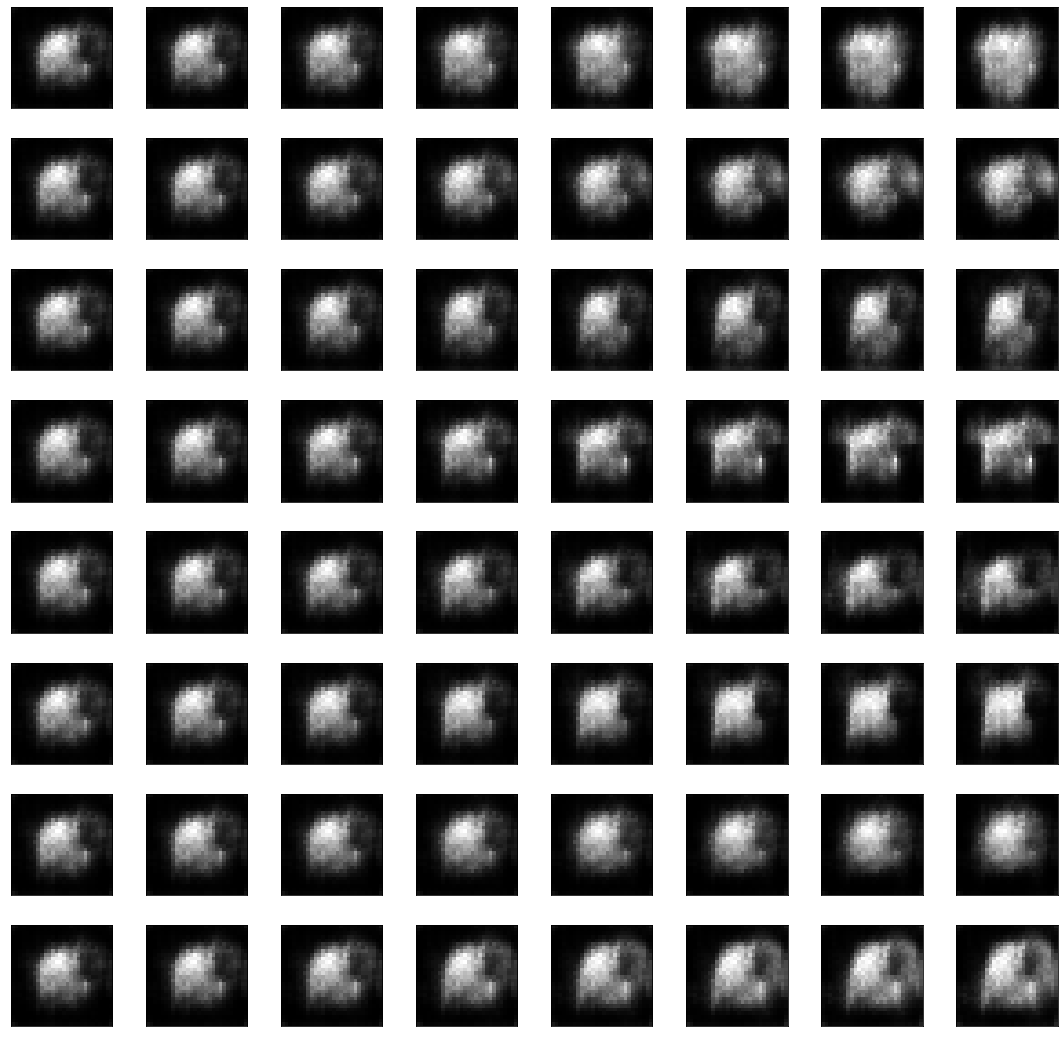

In [23]:
zeros=torch.zeros(10,64)
c=0
for i in zeros:
    
    zeros[c,c]+=1
    c+=1
    if c==10:
        c=0
        
    
range_=np.linspace(0,1,8)
samples=(torch.ones(8,64)*0.1).T
for c in range(64):
    samples[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(samples.to(device))
plot_examples(model=True,data=smple_pic)

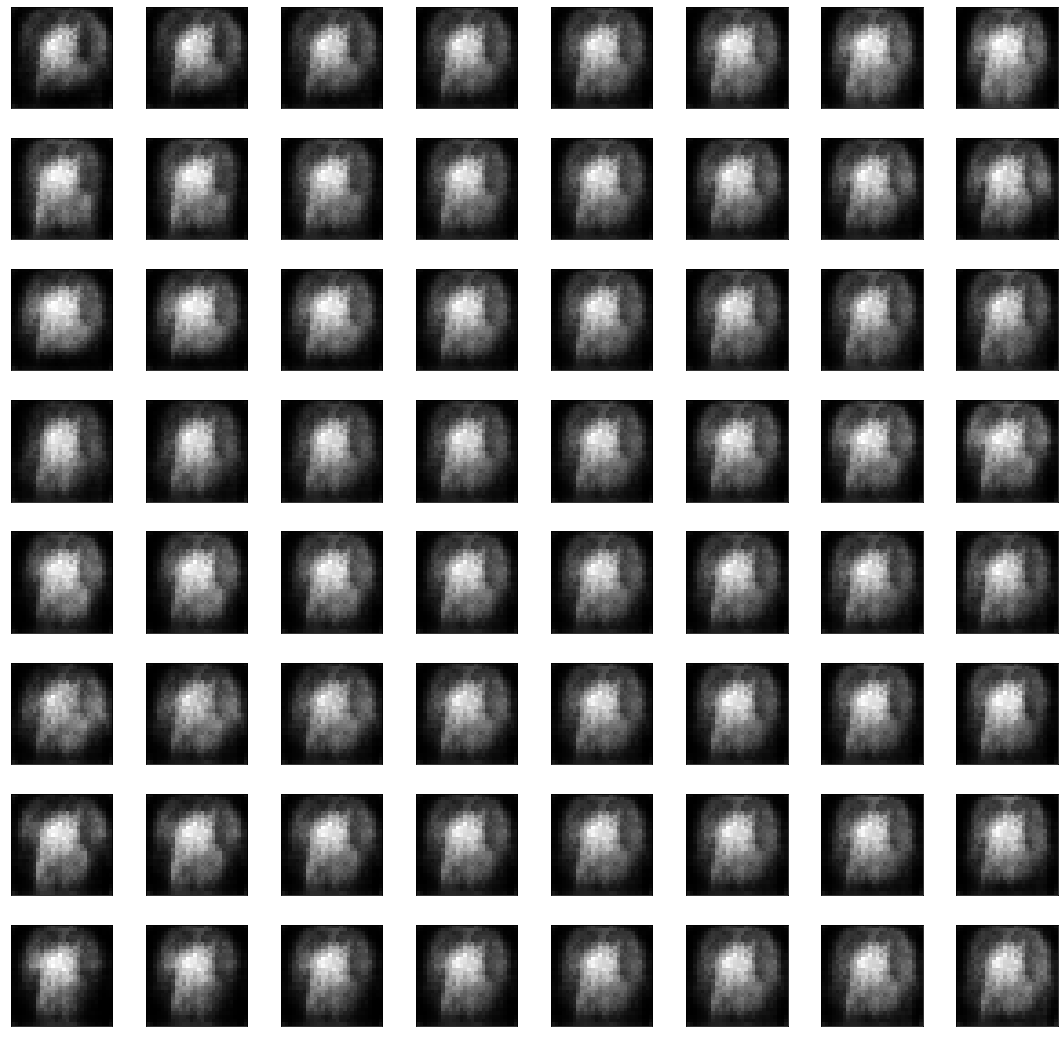

In [24]:
zeros=torch.zeros(10,64)
c=0
for i in zeros:
    
    zeros[c,c]+=1
    c+=1
    if c==10:
        c=0
        
    
range_=np.linspace(0,1,8)
samples=(torch.ones(8,64)*0.6).T
for c in range(64):
    samples[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(samples.to(device))
plot_examples(model=True,data=smple_pic)